# Analysis of Nvdia Stock

In [ ]:
# Import requried Libraries
import numpy as np
import scipy.stats as ss
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import math
import warnings
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.express as px

warnings.filterwarnings('ignore')


def plotly_plot(timevec, Y_GARCH, lrets_close, title=''):
  # def enable_plotly_in_cell():
  #   display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  #   init_notebook_mode(connected=False)

  fig = go.Figure()
  fig.add_trace(go.Scatter( x = list(timevec), y = list(lrets_close), name = 'Actual Log returns',  mode='lines',  line = dict(color='royalblue', width=4)))
  fig.add_trace(go.Scatter( x = list(timevec),    y = list(Y_GARCH),    name = 'Predicted Log returns', mode='lines',line = dict(color='firebrick', width=2)))
  fig.update_layout(
    title={
        'text': title
        })
  # enable_plotly_in_cell()
  iplot(fig)

def plotly_plot_withbg(timevec, lrets_close, Y_GARCH, x0, x1, title=''):
  fig = go.Figure()
  fig.add_trace(go.Scatter( x = list(timevec), y = list(lrets_close), name = 'Actual Log returns',  mode='lines',  line = dict(color='royalblue', width=4)))
  fig.add_trace(go.Scatter( x = list(timevec),    y = list(Y_GARCH),    name = 'Predicted Log returns', mode='lines',line = dict(color='firebrick', width=2)))
  
  fig.update_layout(
    shapes=[
        # 1st highlight during Feb 4 - Feb 6
        dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=x0,
            y0=0,
            x1=x1,
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0
    )],
    title={
        'text': title
        })
  # enable_plotly_in_cell()
  iplot(fig)


### Loading the dataset

In [ ]:
df = pd.read_csv("/content/NVIDIA_FACTORS.csv",decimal =',') 
df.tail()

,Unnamed: 0,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,High,Low,Open,Close,Volume,Adj Close
1084,1084,2020-04-24,1.44,0.29,-0.09,-0.14,0.16,0.0,-20.7170271463498,289.6700134277344,280.6000061035156,283.6000061035156,289.5899963378906,8816100.0,289.4578857421875
1085,1085,2020-04-27,1.73,2.2,2.74,-0.12,0.2,0.0,-18.0607974368507,303.5,294.0,294.989990234375,297.0799865722656,11984700.0,296.9444580078125
1086,1086,2020-04-28,-0.44,1.65,2.89,1.39,0.74,0.0,-17.0617840800563,304.20001220703125,291.1400146484375,303.0,291.3599853515625,11072600.0,291.2270812988281
1087,1087,2020-04-29,2.92,2.27,2.04,1.22,-0.81,0.0,-16.0129046905021,300.5799865722656,293.75,296.7699890136719,298.4599914550781,9479000.0,298.3238525390625
1088,1088,2020-04-30,-1.18,-2.06,-1.63,0.71,-0.1,0.0,-14.9140337495825,298.4599914550781,291.7200012207031,296.2900085449219,292.2799987792969,9372900.0,292.14666748046875


In [ ]:
df_mkt = pd.read_csv("/content/NVIDIA_MARKET_FACTORS.csv",decimal =',') 
df_mkt.tail()

,Unnamed: 0,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,Close,QCOMClose,INTCClose,AMDClose,NASDAQClose,DJIClose,SPYClose
1084,1084,2020-04-24,1.44,0.29,-0.09,-0.14,0.16,0.0,-20.7170271463498,264.80999755859375,76.04000091552734,59.2599983215332,56.18000030517578,8634.51953125,23775.26953125,282.9700012207031
1085,1085,2020-04-27,1.73,2.2,2.74,-0.12,0.2,0.0,-18.0607974368507,268.45001220703125,75.9800033569336,59.470001220703125,56.4900016784668,8730.16015625,24133.779296875,287.04998779296875
1086,1086,2020-04-28,-0.44,1.65,2.89,1.39,0.74,0.0,-17.0617840800563,264.7300109863281,75.29000091552734,58.75,55.5099983215332,8607.73046875,24101.55078125,285.7300109863281
1087,1087,2020-04-29,2.92,2.27,2.04,1.22,-0.81,0.0,-16.0129046905021,276.0199890136719,78.97000122070312,61.79999923706055,53.65999984741211,8914.7099609375,24633.859375,293.2099914550781
1088,1088,2020-04-30,-1.18,-2.06,-1.63,0.71,-0.1,0.0,-14.9140337495825,271.6199951171875,78.66999816894531,59.97999954223633,52.38999938964844,8889.5498046875,24345.720703125,290.4800109863281


In [ ]:
df_pca = pd.read_csv("/content/PCA_MARKET_NVIDIA.csv",decimal =',') 
df_pca.tail()

,Unnamed: 0,pca1,pca2,pca3,pca4,pca5,date
1084,1084,0.43798560356137983,-1.0589890647490217,-0.4151848044402203,-0.0341437105931993,0.07471053529895468,2020-04-24
1085,1085,0.4609158565383964,-1.0159129505801447,-0.30833433221117773,-0.20110872934704974,0.09753699399831041,2020-04-27
1086,1086,0.4280212023134872,-0.9793576802879322,-0.270895402302535,-0.4909834097882223,0.37298697283560034,2020-04-28
1087,1087,0.5217570118321638,-0.999994647315726,-0.2291943947662642,-0.06871652116793833,0.404512274447946,2020-04-29
1088,1088,0.4837277801054676,-0.9722180028589231,-0.23940366217308162,0.04798435625861823,0.29020921864506155,2020-04-30


In [ ]:
df_pca.columns

Index(['Unnamed: 0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'date'], dtype='object')

### CANDLESTICKS MODEL

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

layout = dict(
        title="NVDA",
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title( text="Time"), rangeslider=dict (visible = False)),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title( text="Price $ - US Dollars")),
)
data=[go.Candlestick(x=df.date,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)]
figSignal = go.Figure(data=data, layout=layout)
figSignal.show()


## Candlestick Patterns


In [ ]:

def candle_score(lst_0,lst_1,lst_2):    
    
    O_0,H_0,L_0,C_0=lst_0[0],lst_0[1],lst_0[2],lst_0[3]
    O_1,H_1,L_1,C_1=lst_1[0],lst_1[1],lst_1[2],lst_1[3]
    O_2,H_2,L_2,C_2=lst_2[0],lst_2[1],lst_2[2],lst_2[3]
    
    DojiSize = 0.1
    
    doji=(abs(O_0 - C_0) <= (H_0 - L_0) * DojiSize)
    
    hammer=(((H_0 - L_0)>3*(O_0 -C_0)) &  ((C_0 - L_0)/(.001 + H_0 - L_0) > 0.6) & ((O_0 - L_0)/(.001 + H_0 - L_0) > 0.6))
    
    inverted_hammer=(((H_0 - L_0)>3*(O_0 -C_0)) &  ((H_0 - C_0)/(.001 + H_0 - L_0) > 0.6) & ((H_0 - O_0)/(.001 + H_0 - L_0) > 0.6))
    
    bullish_reversal= (O_2 > C_2)&(O_1 > C_1)&doji
    
    bearish_reversal= (O_2 < C_2)&(O_1 < C_1)&doji
    
    evening_star=(C_2 > O_2) & (min(O_1, C_1) > C_2) & (O_0 < min(O_1, C_1)) & (C_0 < O_0 )
    
    morning_star=(C_2 < O_2) & (min(O_1, C_1) < C_2) & (O_0 > min(O_1, C_1)) & (C_0 > O_0 )
    
    shooting_Star_bearish=(O_1 < C_1) & (O_0 > C_1) & ((H_0 - max(O_0, C_0)) >= abs(O_0 - C_0) * 3) & ((min(C_0, O_0) - L_0 )<= abs(O_0 - C_0)) & inverted_hammer
    
    shooting_Star_bullish=(O_1 > C_1) & (O_0 < C_1) & ((H_0 - max(O_0, C_0)) >= abs(O_0 - C_0) * 3) & ((min(C_0, O_0) - L_0 )<= abs(O_0 - C_0)) & inverted_hammer
    
    bearish_harami=(C_1 > O_1) & (O_0 > C_0) & (O_0 <= C_1) & (O_1 <= C_0) & ((O_0 - C_0) < (C_1 - O_1 ))
    
    Bullish_Harami=(O_1 > C_1) & (C_0 > O_0) & (C_0 <= O_1) & (C_1 <= O_0) & ((C_0 - O_0) < (O_1 - C_1))
    
    Bearish_Engulfing=((C_1 > O_1) & (O_0 > C_0)) & ((O_0 >= C_1) & (O_1 >= C_0)) & ((O_0 - C_0) > (C_1 - O_1 ))
    
    Bullish_Engulfing=(O_1 > C_1) & (C_0 > O_0) & (C_0 >= O_1) & (C_1 >= O_0) & ((C_0 - O_0) > (O_1 - C_1 ))
    
    Piercing_Line_bullish=(C_1 < O_1) & (C_0 > O_0) & (O_0 < L_1) & (C_0 > C_1)& (C_0>((O_1 + C_1)/2)) & (C_0 < O_1)

    Hanging_Man_bullish=(C_1 < O_1) & (O_0 < L_1) & (C_0>((O_1 + C_1)/2)) & (C_0 < O_1) & hammer

    Hanging_Man_bearish=(C_1 > O_1) & (C_0>((O_1 + C_1)/2)) & (C_0 < O_1) & hammer

    strCandle=''
    candle_score=0
    
    if doji:
        strCandle='doji'
    if evening_star:
        strCandle=strCandle+'/ '+'evening_star'
        candle_score=candle_score-1
    if morning_star:
        strCandle=strCandle+'/ '+'morning_star'
        candle_score=candle_score+1
    if shooting_Star_bearish:
        strCandle=strCandle+'/ '+'shooting_Star_bearish'
        candle_score=candle_score-1
    if shooting_Star_bullish:
        strCandle=strCandle+'/ '+'shooting_Star_bullish'
        candle_score=candle_score-1
    if    hammer:
        strCandle=strCandle+'/ '+'hammer'
    if    inverted_hammer:
        strCandle=strCandle+'/ '+'inverted_hammer'
    if    bearish_harami:
        strCandle=strCandle+'/ '+'bearish_harami'
        candle_score=candle_score-1
    if    Bullish_Harami:
        strCandle=strCandle+'/ '+'Bullish_Harami'
        candle_score=candle_score+1
    if    Bearish_Engulfing:
        strCandle=strCandle+'/ '+'Bearish_Engulfing'
        candle_score=candle_score-1
    if    bullish_reversal:
        strCandle=strCandle+'/ '+'Bullish_Engulfing'
        candle_score=candle_score+1
    if    bullish_reversal:
        strCandle=strCandle+'/ '+'bullish_reversal'
        candle_score=candle_score+1
    if    bearish_reversal:
        strCandle=strCandle+'/ '+'bearish_reversal'
        candle_score=candle_score-1
    if    Piercing_Line_bullish:
        strCandle=strCandle+'/ '+'Piercing_Line_bullish'
        candle_score=candle_score+1
    if    Hanging_Man_bearish:
        strCandle=strCandle+'/ '+'Hanging_Man_bearish'
        candle_score=candle_score-1
    if    Hanging_Man_bullish:
        strCandle=strCandle+'/ '+'Hanging_Man_bullish'
        candle_score=candle_score+1
        
    return candle_score,strCandle

In [ ]:
def candle_df(df):
    #df_candle=first_letter_upper(df)
    df_candle=df.copy()
    df_candle['Open']= df_candle['Open'].astype(np.float64)
    df_candle['High']= df_candle['High'].astype(np.float64)
    df_candle['Low']= df_candle['Low'].astype(np.float64)
    df_candle['Close']= df_candle['Close'].astype(np.float64)
    df_candle['candle_score']=0
    df_candle['candle_pattern']=''


    for c in range(2,len(df_candle)):
        cscore,cpattern=0,''
        lst_2=[df_candle['Open'].iloc[c-2],df_candle['High'].iloc[c-2],df_candle['Low'].iloc[c-2],df_candle['Close'].iloc[c-2]]
        lst_1=[df_candle['Open'].iloc[c-1],df_candle['High'].iloc[c-1],df_candle['Low'].iloc[c-1],df_candle['Close'].iloc[c-1]]
        lst_0=[df_candle['Open'].iloc[c],df_candle['High'].iloc[c],df_candle['Low'].iloc[c],df_candle['Close'].iloc[c]]
        cscore,cpattern=candle_score(lst_0,lst_1,lst_2)    
        df_candle['candle_score'].iat[c]=cscore
        df_candle['candle_pattern'].iat[c]=cpattern
    
    df_candle['candle_cumsum']=df_candle['candle_score'].rolling(3).sum()
    
    return df_candle

In [ ]:
df_candle= candle_df(df)

df_candle['signal']=np.where(df_candle['candle_cumsum']>1,1,-1)
df_candle['signal2']=np.where(df_candle['signal']==df_candle['signal'].shift(1),0,df_candle['signal'])



'''
Let us consider whenever we square off the position, we are taking another position on reverse side.
'''

df_returns=df_candle[df_candle['signal2']!=0].copy()
df_returns['units']=2
df_returns['units'].iat[0],df_returns['units'].iat[-1]=1,1



'''
Let us check the total transactions and total returns we made
'''

print('Total transactions are :', df_returns[df_returns['signal2']==1].signal2.sum())

print('Total returns are :', ((df_returns['signal2']*df_returns['units']*df_returns['Close']).sum())*-1)


Total transactions are : 46
Total returns are : -318.16001892089844


In [ ]:
df_candle= df_candle[df_candle['candle_pattern']!=''][['date', 'High', 'Low', 'candle_pattern']]
df_candle=df_candle.reset_index(drop=True)
df_candle

,date,High,Low,candle_pattern
0,2016-01-06,32.500000,31.160000,/ evening_star
1,2016-01-11,29.889999,29.150000,doji/ morning_star/ hammer/ Bullish_Harami/ Bu...
2,2016-01-12,30.620001,29.969999,doji/ inverted_hammer
3,2016-01-14,29.000000,27.820000,doji/ hammer/ Bullish_Engulfing/ bullish_reversal
4,2016-01-19,28.450001,27.219999,/ inverted_hammer
...,...,...,...,...
426,2020-04-20,293.500000,285.269989,doji/ inverted_hammer
427,2020-04-22,287.869995,275.399994,/ morning_star
428,2020-04-27,303.500000,294.000000,/ morning_star/ shooting_Star_bearish/ inverte...
429,2020-04-28,304.200012,291.140015,/ Bearish_Engulfing


In [ ]:
from datetime import datetime, timedelta
mdict=[]
for i in range(2,len(df_candle)):
  x=dict(
            type="circle",
            x0=((datetime.strptime(df_candle.date[i], '%Y-%m-%d') - timedelta(days=2)).strftime("%Y-%m-%d")),
            y0=df_candle.Low[i],
            x1=((datetime.strptime(df_candle.date[i], '%Y-%m-%d') + timedelta(days=2)).strftime("%Y-%m-%d")),
            y1=df_candle.High[i],
        )
  mdict.append(x)
mdict



[{'type': 'circle',
  'x0': '2016-01-10',
  'x1': '2016-01-14',
  'y0': 29.969999313354492,
  'y1': 30.6200008392334},
 {'type': 'circle',
  'x0': '2016-01-12',
  'x1': '2016-01-16',
  'y0': 27.81999969482422,
  'y1': 29.0},
 {'type': 'circle',
  'x0': '2016-01-17',
  'x1': '2016-01-21',
  'y0': 27.219999313354492,
  'y1': 28.450000762939453},
 {'type': 'circle',
  'x0': '2016-01-19',
  'x1': '2016-01-23',
  'y0': 27.209999084472656,
  'y1': 28.229999542236328},
 {'type': 'circle',
  'x0': '2016-01-23',
  'x1': '2016-01-27',
  'y0': 28.360000610351562,
  'y1': 28.770000457763672},
 {'type': 'circle',
  'x0': '2016-01-27',
  'x1': '2016-01-31',
  'y0': 28.18000030517578,
  'y1': 29.350000381469727},
 {'type': 'circle',
  'x0': '2016-01-30',
  'x1': '2016-02-03',
  'y0': 29.010000228881836,
  'y1': 29.450000762939453},
 {'type': 'circle',
  'x0': '2016-02-01',
  'x1': '2016-02-05',
  'y0': 27.549999237060547,
  'y1': 28.450000762939453},
 {'type': 'circle',
  'x0': '2016-02-02',
  'x1': 

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

layout = dict(
        title="NVDA",
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title( text="Time"), rangeslider=dict (visible = False)),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title( text="Price $ - US Dollars")),
)
data=[go.Candlestick(x=df.date,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)]
figSignal = go.Figure(data=data, layout=layout)

figSignal.add_trace(go.Scatter(
    x=df_candle.date,
    y=df_candle.Low-3,
    text=df_candle.candle_pattern,
    mode="text",
))

figSignal.update_layout(
    shapes=mdict
)


figSignal.show()


In [ ]:
df

,Unnamed: 0,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,High,Low,Open,Close,Volume,Adj Close
0,0,2016-01-04,-1.59,-0.73,0.53,0.35,0.42,0.0,-0.336954191985771,32.58000183105469,32.040000915527344,32.290000915527344,32.369998931884766,8951900.0,31.691171646118164
1,1,2016-01-05,0.12,-0.25,0.01,0.03,0.35,0.0,-0.322184625246708,33.439998626708984,32.5,32.97999954223633,32.88999938964844,12256800.0,32.20025634765625
2,2,2016-01-06,-1.35,-0.21,-0.01,0.15,0.04,0.0,-0.308062368324326,32.5,31.15999984741211,32.349998474121094,31.530000686645508,11233600.0,30.8687801361084
3,3,2016-01-07,-2.44,-0.27,0.08,0.48,0.43,0.0,-0.294585731218786,30.950000762939453,29.8799991607666,30.739999771118164,30.280000686645508,16132600.0,29.644996643066406
4,4,2016-01-08,-1.11,-0.52,-0.03,0.21,0.04,0.0,-0.28175310119109,30.700000762939453,29.56999969482422,30.670000076293945,29.6299991607666,9961800.0,29.00862693786621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,1084,2020-04-24,1.44,0.29,-0.09,-0.14,0.16,0.0,-20.7170271463498,289.6700134277344,280.6000061035156,283.6000061035156,289.5899963378906,8816100.0,289.4578857421875
1085,1085,2020-04-27,1.73,2.2,2.74,-0.12,0.2,0.0,-18.0607974368507,303.5,294.0,294.989990234375,297.0799865722656,11984700.0,296.9444580078125
1086,1086,2020-04-28,-0.44,1.65,2.89,1.39,0.74,0.0,-17.0617840800563,304.20001220703125,291.1400146484375,303.0,291.3599853515625,11072600.0,291.2270812988281
1087,1087,2020-04-29,2.92,2.27,2.04,1.22,-0.81,0.0,-16.0129046905021,300.5799865722656,293.75,296.7699890136719,298.4599914550781,9479000.0,298.3238525390625


In [ ]:
from datetime import datetime, timedelta
Previous_Date =(datetime.strptime('2017-08-08', '%Y-%m-%d') - timedelta(days=2)).strftime("%Y-%m-%d")
print(Previous_Date)
type(Previous_Date)
((datetime.strptime(df.date[402], '%Y-%m-%d') - timedelta(days=2)).strftime("%Y-%m-%d"))

2017-08-06


'2017-08-06'

In [ ]:
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
trace = go.Candlestick(x=df.date,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)
data = [trace]
iplot(data, filename='simple_candlestick')


#### MODELS

In [ ]:
df.columns

Index(['Unnamed: 0', 'date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF',
       'ADS_Index', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'],
      dtype='object')

In [ ]:
df_mkt.columns

Index(['Unnamed: 0', 'date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF',
       'ADS_Index', 'Close', 'QCOMClose', 'INTCClose', 'AMDClose',
       'NASDAQClose', 'DJIClose', 'SPYClose'],
      dtype='object')

In [ ]:
# df_mkt['Mkt-RF']=df_mkt['Mkt-RF'].astype(float)
# df_mkt['Close']=df_mkt['Close'].astype(float)
# df_mkt['SMB']=df['SMB'].astype(float)
# df_mkt['HML']=df['HML'].astype(float)
# df_mkt['RMW']=df_mkt['RMW'].astype(float)
# df_mkt['CMA']=df_mkt['CMA'].astype(float)
# df_mkt['RF']=df_mkt['RF'].astype(float)
# df_mkt['ADS_Index']=df_mkt['ADS_Index'].astype(float)
df_mkt['QCOMClose']=df_mkt['QCOMClose'].astype(float)
df_mkt['INTCClose']=df_mkt['INTCClose'].astype(float)
df_mkt['AMDClose']=df_mkt['AMDClose'].astype(float)
df_mkt['NASDAQClose']=df_mkt['NASDAQClose'].astype(float)
df_mkt['DJIClose']=df_mkt['DJIClose'].astype(float)
df_mkt['SPYClose']=df_mkt['SPYClose'].astype(float)
df_mkt['Close']=df_mkt['Close'].astype(float)

df_mkt['Log_Close']= np.log(df_mkt['Close']/df_mkt['Close'].shift(1))
df_mkt['QCOMLog_Close']= np.log(df_mkt['QCOMClose']/df_mkt['QCOMClose'].shift(1))
df_mkt['NASDAQLog_Close']= np.log(df_mkt['NASDAQClose']/df_mkt['NASDAQClose'].shift(1))
df_mkt['AMDLog_Close']= np.log(df_mkt['AMDClose']/df_mkt['AMDClose'].shift(1))
df_mkt['SPYLog_Close']= np.log(df_mkt['SPYClose']/df_mkt['SPYClose'].shift(1))
df_mkt['INTCLog_Close']= np.log(df_mkt['INTCClose']/df_mkt['INTCClose'].shift(1))
df_mkt['DJILog_Close']= np.log(df_mkt['DJIClose']/df_mkt['DJIClose'].shift(1))
df_mkt=df_mkt[['date','Log_Close','QCOMLog_Close','DJILog_Close','INTCLog_Close','NASDAQLog_Close','AMDLog_Close','SPYLog_Close']]
df_mkt=df_mkt.dropna()

In [ ]:
df_mkt['date']= pd.to_datetime(df_mkt['date']) 
df_mkt['date']=df_mkt['date'].dt.date

In [ ]:
df_pca['pca1']=df_pca['pca1'].astype(float)
df_pca['pca2']=df_pca['pca2'].astype(float)
df_pca['pca3']=df_pca['pca3'].astype(float)
df_pca['pca4']=df_pca['pca4'].astype(float)
df_pca['pca5']=df_pca['pca5'].astype(float)
df_pca['date']= pd.to_datetime(df_pca['date']) 
df_pca['date']=df_pca['date'].dt.date
df_pca=df_pca[['pca1','pca2','pca3','pca4','pca5','date']].dropna()

In [ ]:
df['Mkt-RF']=df['Mkt-RF'].astype(float)
df['Close']=df['Close'].astype(float)
df['SMB']=df['SMB'].astype(float)
df['HML']=df['HML'].astype(float)
df['RMW']=df['RMW'].astype(float)
df['CMA']=df['CMA'].astype(float)
df['RF']=df['RF'].astype(float)
df['ADS_Index']=df['ADS_Index'].astype(float)

df['Log_Close']= np.log(df['Close']/df['Close'].shift(1))
df=df.dropna()

In [ ]:
df=df.head(503)
df_mkt=df_mkt.head(503)
df_pca=df_pca.head(503)

df.head()

,Unnamed: 0,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,High,Low,Open,Close,Volume,Adj Close,Log_Close
1,1,2016-01-05,0.12,-0.25,0.01,0.03,0.35,0.0,-0.322185,33.439998626708984,32.5,32.97999954223633,32.889999,12256800.0,32.20025634765625,0.015937
2,2,2016-01-06,-1.35,-0.21,-0.01,0.15,0.04,0.0,-0.308062,32.5,31.15999984741211,32.349998474121094,31.530001,11233600.0,30.8687801361084,-0.042229
3,3,2016-01-07,-2.44,-0.27,0.08,0.48,0.43,0.0,-0.294586,30.950000762939453,29.8799991607666,30.739999771118164,30.280001,16132600.0,29.644996643066406,-0.040452
4,4,2016-01-08,-1.11,-0.52,-0.03,0.21,0.04,0.0,-0.281753,30.700000762939453,29.56999969482422,30.670000076293945,29.629999,9961800.0,29.00862693786621,-0.021700
5,5,2016-01-11,-0.06,-0.62,0.34,0.65,0.43,0.0,-0.247350,29.889999389648438,29.149999618530273,29.65999984741211,29.680000,10234300.0,29.05758285522461,0.001686


In [ ]:
df1 = df[['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','ADS_Index', 'Log_Close']].dropna().reset_index(drop=True)
df2=df1

In [ ]:
df2['Mkt-RF-sq'] = df2['Mkt-RF']*df2['Mkt-RF']
df2['Mkt-RF_CMA'] = df2['Mkt-RF']*df2['CMA']
df2['Mkt-RF_SMB'] = df2['Mkt-RF']*df2['SMB']
df2['SMB-sq'] = df2['SMB']*df2['SMB']
df2['RMW-sq']=df2['RMW']*df2['RMW']


In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999999


<IPython.core.display.Javascript object>

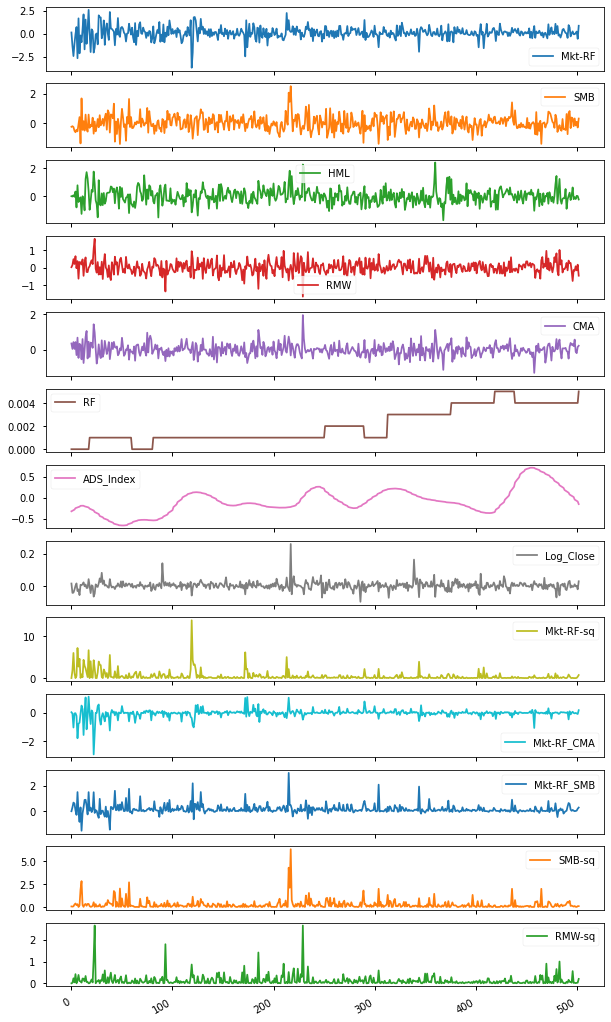

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
df2.plot(subplots= True, figsize=(10,20))
plt.show()

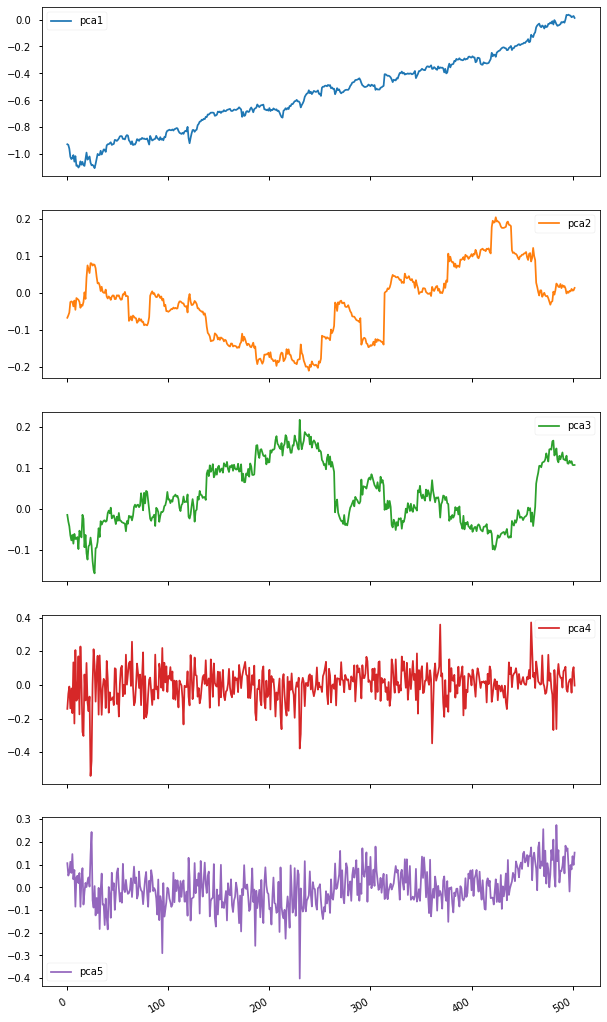

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
df_pca.plot(subplots= True, figsize=(10,20))
plt.show()

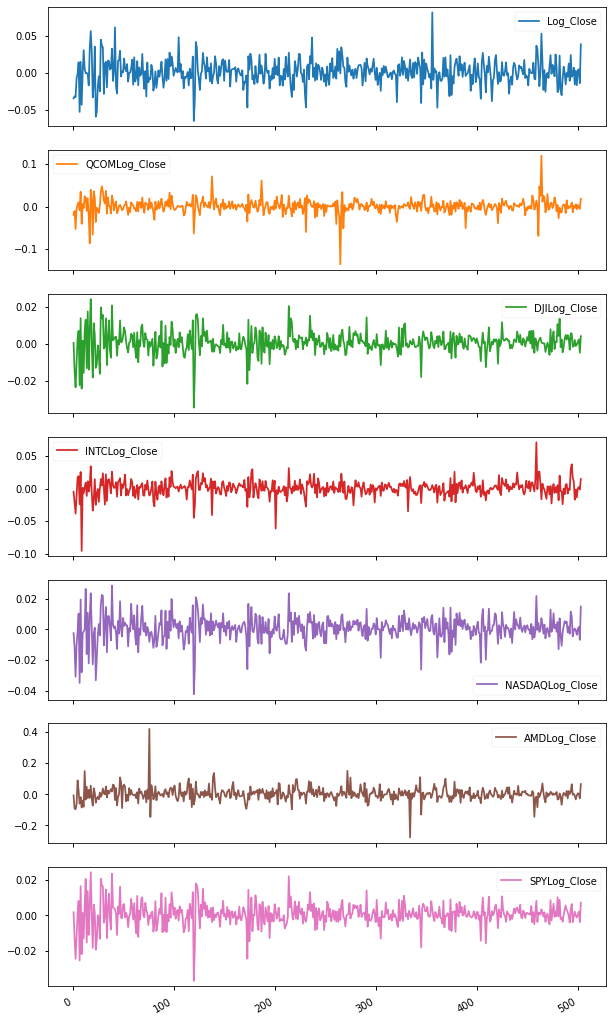

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
df_mkt.plot(subplots= True, figsize=(10,20))
plt.show()

# Functions


In [ ]:
def linear(Xt,Yt):
    invXX = np.linalg.inv(Xt.transpose()@Xt)
    beta_hat = invXX@Xt.transpose()@Yt
    #y_hat = Xt@beta_hat
    return  beta_hat 


In [ ]:

def GARCH(param0, Y1):
    #print(Y1)
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y1.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    sigma2[0] = omega/(1-alpha)
    
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y1[t-1]-mu)**2)+beta*(sigma2[t-1])
        F[t] = Y1[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t];
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+\
                     (1/2)*(F[t]/v[t]);
    Likelihood = np.sum(GARCH_Dens[1:-1])
    return Likelihood

def GARCH_PROD(params,T,Y0):
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    Y = np.zeros(T)
    Y[0]= Y0
    sigma2 = np.zeros(T)
    sigma2[0]= omega/(1-alpha)
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)
    return Y

In [ ]:

def Kalman_Filter(param0, Y):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = param0[0]
 T = param0[1]
 H = param0[2]
 Q = param0[3]
 "Kalman Filter Starts:"
 ### State prices in original time series
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 ## Observation prices 
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)  #Forecast error
 F = np.zeros(S)  #
 KF_Dens = np.zeros(S)
 for s in range(1,S):
   ##Initialising the first price
  if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
  else:
    ##We aim to find distribution of state given new observation
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H     
    v[s]=Y[s-1]-Z*u_predict[s-1]    #Forecast error
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    ##Forecasting
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
    Likelihood = np.sum(KF_Dens[1:-1])  
    return Likelihood


In [ ]:
def Kalman_Smoother(params,YKS):
    S=YKS.shape[0]
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    #Kalman Filter Starts
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    p_predict = np.zeros(S)
    p_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)

    for s in range(1,S):
        if s ==1:
            p_update[s] =1000
            p_predict[s] = T*p_update[1]*np.transpose(T)+Q
        else:
            F[s] = Z*p_predict[s-1]*np.transpose(Z)+H
            v[s] = YKS[s-1]-Z*u_predict[s-1]
            
            u_update[s] =T*u_update[s-1]+p_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_update[s]

            p_update[s] = p_predict[s-1]-p_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*p_predict[s-1]
            p_predict[s] = T*p_update[s]*np.transpose(T)+Q
        
    u_smooth = np.zeros(S)
    p_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    p_smooth[S-1] = p_update[S-1]
    for t in range (S-1,0,-1):
        u_smooth[t-1] =u_update[t]+p_update[t]*np.transpose(T)/p_predict[t]*(u_smooth[t]-T*u_update[t])
        p_smooth[t-1] = p_update[t]+p_update[t]*np.transpose(T)/p_predict[t]*(p_smooth[t]-p_predict[t])/p_predict[t]
    return u_smooth

 ## make sure there is no multicolinearity and for adding significant quadratic variables




In [ ]:
df=df[['Mkt-RF','SMB','HML','RMW','CMA','RF','ADS_Index','Log_Close']]
correlationval=df.corr(method ='pearson') 
correlationval

,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,Log_Close
Mkt-RF,1.000000,0.380249,0.110081,-0.328996,-0.126932,0.032717,0.000971,0.383666
SMB,0.380249,1.000000,0.135491,-0.237660,0.099159,-0.018450,-0.029919,0.246321
HML,0.110081,0.135491,1.000000,-0.167155,0.580534,-0.056422,-0.033391,-0.179472
RMW,-0.328996,-0.237660,-0.167155,1.000000,-0.077124,0.005011,0.071935,-0.143587
CMA,-0.126932,0.099159,0.580534,-0.077124,1.000000,-0.070227,-0.081550,-0.223582
RF,0.032717,-0.018450,-0.056422,0.005011,-0.070227,1.000000,0.468214,-0.012454
ADS_Index,0.000971,-0.029919,-0.033391,0.071935,-0.081550,0.468214,1.000000,-0.010078
Log_Close,0.383666,0.246321,-0.179472,-0.143587,-0.223582,-0.012454,-0.010078,1.000000


In [ ]:
correlationval2=df_mkt.corr(method ='pearson') 
correlationval2

,Log_Close,QCOMLog_Close,DJILog_Close,INTCLog_Close,NASDAQLog_Close,AMDLog_Close,SPYLog_Close
Log_Close,1.000000,0.427989,0.531914,0.505970,0.710338,0.289860,0.604400
QCOMLog_Close,0.427989,1.000000,0.442442,0.354759,0.500331,0.250346,0.496925
DJILog_Close,0.531914,0.442442,1.000000,0.612608,0.826833,0.291440,0.948131
INTCLog_Close,0.505970,0.354759,0.612608,1.000000,0.656126,0.257772,0.626142
NASDAQLog_Close,0.710338,0.500331,0.826833,0.656126,1.000000,0.346975,0.921001
AMDLog_Close,0.289860,0.250346,0.291440,0.257772,0.346975,1.000000,0.321397
SPYLog_Close,0.604400,0.496925,0.948131,0.626142,0.921001,0.321397,1.000000


In [ ]:
correlationval3=df_pca.corr(method ='pearson') 
correlationval3

,pca1,pca2,pca3,pca4,pca5
pca1,1.000000,0.398259,0.172959,0.169883,0.331535
pca2,0.398259,1.000000,-0.765015,0.055921,0.250925
pca3,0.172959,-0.765015,1.000000,-0.140172,-0.122780
pca4,0.169883,0.055921,-0.140172,1.000000,-0.051938
pca5,0.331535,0.250925,-0.122780,-0.051938,1.000000


# Split Dataset



In [ ]:
Selected Dataset - Variables used for training

X=df2[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_Index']]
X2=df2[[ 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_Index','Mkt-RF-sq', 'Mkt-RF_CMA', 'Mkt-RF_SMB', 'SMB-sq', 'RMW-sq']]
X3=df2[[ 'Mkt-RF-sq', 'Mkt-RF_CMA', 'Mkt-RF_SMB', 'SMB-sq', 'RMW-sq']]

XFF = df2[["Mkt-RF","SMB","HML"]]
X_Market=df_mkt[['QCOMLog_Close','DJILog_Close','INTCLog_Close','NASDAQLog_Close','AMDLog_Close','SPYLog_Close']]
X_pca=df_pca[['pca1','pca2','pca3','pca4','pca5']]
#Target Variable

Y=df2['Log_Close']

#Target variable Y as next day Opening value
#Y=df['Log_Close'].shift(-1).as_matrix()

T=df2.shape[0]

X=np.column_stack([np.ones((T,1)),X])
X2=np.column_stack([np.ones((T,1)),X2])
X3=np.column_stack([np.ones((T,1)),X3])
XFF=np.column_stack([np.ones((T,1)),XFF])
X_Market=np.column_stack([np.ones((T,1)),X_Market])
X_pca=np.column_stack([np.ones((T,1)),X_pca])


#Random Split into Train and test with pareto principle of 80:20
train_size = int(len(X) * 0.8)
#train, test = X[0:train_size], X[train_size:len(X)]

train_size2= int(len(X2) * 0.8)
train_size3= int(len(X3) * 0.8)
train_sizeFF= int(len(XFF) * 0.8)
train_sizeMarket= int(len(X_Market) * 0.8)
train_sizepca= int(len(X_pca) * 0.8)



df2_test_dates= df2[['date']]
df2_dates= df2[['date']]
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], Y[:train_size], Y[train_size:] 
X_train2, X_test2, y_train2, y_test2 = X2[:train_size2], X2[train_size2:], Y[:train_size2], Y[train_size2:] 
X_train3, X_test3, y_train3, y_test3 = X3[:train_size3], X3[train_size3:], Y[:train_size3], Y[train_size3:]
X_trainFF, X_testFF, y_trainFF, y_testFF = XFF[:train_sizeFF], XFF[train_sizeFF:], Y[:train_sizeFF], Y[train_sizeFF:] 

X_trainpca, X_testpca, y_trainpca, y_testpca = X[:train_sizepca], X[train_sizepca:], Y[:train_sizepca], Y[train_sizepca:] 
X_trainMarket, X_testMarket, y_trainMarket, y_testMarket = X[:train_sizeMarket], X[train_sizeMarket:], Y[:train_sizeMarket], Y[train_sizeMarket:] 



In [ ]:
df2_test_dates=df2_test_dates[train_size:]

In [ ]:

#Linear for Train dataset
beta_hat_linear=linear(X_train,y_train)
beta_hat_linearFF=linear(X_trainFF,y_trainFF)
beta_hat_linearQcTrain=linear(X_train2,y_train2)
beta_hat_linearQcFewTrain=linear(X_train3,y_train3)
beta_hat_linearMarket=linear(X_trainMarket,y_trainMarket)
beta_hat_linearpca=linear(X_trainpca,y_trainpca)

#Garch for Train dataset
Y1=y_train
meu= np.mean(Y1)
T = len(Y1)
## Garch alpha (0.05,0.1)~ stable stock->unstable stock ;volatility
## Garch beta (0.85,0.98)~ inv prop to alpha ; variance in volatility
## spiky stocks have low alpha, high beta

param0 = np.array([meu,0.00001,0.09,0.89])
param_star_garch = minimize(GARCH, param0, args=(Y1), method ='BFGS', options ={'xtol':1e-8, 'disp':True})
Y_GARCH = GARCH_PROD(param_star_garch.x,len(Y),Y[0])
y_update_GARCH=Y_GARCH
timevec = df2['date']
plotly_plot_withbg(timevec,  Y,y_update_GARCH, '2016-01-05', '2017-08-07', title='GARCH results')




         Current function value: -1992.735813
         Iterations: 0
         Function evaluations: 659
         Gradient evaluations: 109


In [ ]:
## Garch alpha (0.05,0.1)~ stable stock->unstable stock ;volatility
## Garch beta (0.85,0.98)~ inv prop to alpha ; variance in volatility
## spiky stocks have low alpha, high beta

param0 = np.array([meu,0.00001,0.1,0.85])
param_star_garch = minimize(GARCH, param0, args=(Y1), method ='BFGS', options ={'xtol':1e-8, 'disp':True})
Y_GARCH = GARCH_PROD(param_star_garch.x,len(Y),Y[0])
y_update_GARCH=Y_GARCH
""""""
param02 = np.array([meu,0.00001,0.7,0.91])
param_star_garch2= minimize(GARCH, param02, args=(Y1), method ='BFGS', options ={'xtol':1e-8, 'disp':True})
Y_GARCH2 = GARCH_PROD(param_star_garch2.x,len(Y),Y[0])
y_update_GARCH2=Y_GARCH2

param03 = np.array([meu,0.00001,0.5,0.94])
param_star_garch3= minimize(GARCH, param03, args=(Y1), method ='BFGS', options ={'xtol':1e-8, 'disp':True})
Y_GARCH3 = GARCH_PROD(param_star_garch3.x,len(Y),Y[0])
y_update_GARCH3=Y_GARCH3
timevec = df2['date']
plotly_plot_withbg(timevec, Y, y_update_GARCH,  '2016-01-05', '2017-08-07', title='GARCH results')
plotly_plot_withbg(timevec, Y, y_update_GARCH2, '2016-01-05', '2017-08-07', title='GARCH results')
plotly_plot_withbg(timevec, Y, y_update_GARCH3, '2016-01-05', '2017-08-07', title='GARCH results')


         Current function value: nan
         Iterations: 1
         Function evaluations: 672
         Gradient evaluations: 112
         Current function value: -619.285826
         Iterations: 0
         Function evaluations: 81
         Gradient evaluations: 13
         Current function value: -1332.425086
         Iterations: 2
         Function evaluations: 150
         Gradient evaluations: 23


In [ ]:
# Kalman for training
Y1=y_train
T=len(Y1)
param0 = np.array([1.3, 0.9, 0.6, 1])
param_star_kf = minimize(Kalman_Filter, param0,args=(Y), method='BFGS', options={'xtol': 1e-8, 'disp': True})



         Current function value: -0.577108
         Iterations: 6
         Function evaluations: 556
         Gradient evaluations: 92


# Model Predict on test sets


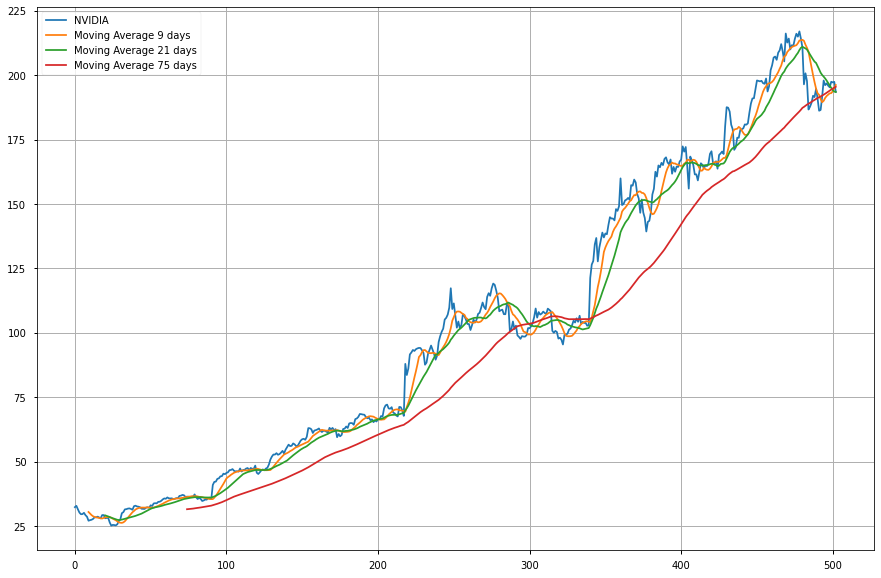

In [ ]:
X=df2[['date','Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_Index']]
timevec = X['date']
Y=df2['Log_Close']
T=len(Y)
X=np.column_stack([np.ones((T,1)),X])
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], Y[:train_size], Y[train_size:]

#   Kalman for test set
Y1=Y
T = len(Y1)
y_update_kf = Kalman_Smoother(param_star_kf.x, Y)
plotly_plot_withbg(timevec, y_update_kf, Y1, '2016-01-05', '2017-08-07', title='KALMAN results')

Y1=Y
T = len(Y1)
X=df2[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_Index']]
X=np.column_stack([np.ones((T,1)),X])
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], Y[:train_size], Y[train_size:]
# beta_hat_linear=linear(X_train, y_train)
# beta_hat_linearFF=linear(X_trainFF,y_trainFF)
# beta_hat_linearQcTrain=linear(X_train2,y_train2)
# beta_hat_linearQcFewTrain=linear(X_train3,y_train3)

y_update_linear = X@beta_hat_linear
y_update_linearFF = XFF@beta_hat_linearFF
y_update_linearQc = X2@beta_hat_linearQcTrain
y_update_linearQcFew = X3@beta_hat_linearQcFewTrain
y_update_linearMarket = X@beta_hat_linearMarket
y_update_linearpca = X@beta_hat_linearpca

plotly_plot_withbg(timevec, y_update_linear, Y1, '2016-01-05', '2017-08-07', title='Linear Regression results')
plotly_plot_withbg(timevec, y_update_linearFF, Y1, '2016-01-05', '2017-08-07', title='Linear RegressionFF results')
plotly_plot_withbg(timevec, y_update_linearQc, Y1, '2016-01-05', '2017-08-07', title='Linear RegressionQc results')
plotly_plot_withbg(timevec, y_update_linearQcFew, Y1, '2016-01-05', '2017-08-07', title='Linear RegressionQcFew results')
plotly_plot_withbg(timevec, y_update_linearMarket, Y1, '2016-01-05', '2017-08-07', title='Linear Regression with competitor stocks and market values')
plotly_plot_withbg(timevec, y_update_linearpca, Y1, '2016-01-05', '2017-08-07', title='Linear Regression with PCA of Market Factors')


# moving average plot
df = pd.read_csv("/content/NVIDIA_FACTORS.csv",decimal =',') 
df=df.head(503)
df['Close']=df['Close'].astype(np.float64)
nvidia_close=pd.DataFrame(df.Close)
nvidia_close['MovingAvg_9'] = nvidia_close.Close.rolling(9).mean().shift()
nvidia_close['MovingAvg_21'] = nvidia_close.Close.rolling(21).mean()
nvidia_close['MovingAvg_75'] = nvidia_close.Close.rolling(75).mean()

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(nvidia_close['Close'],label='NVIDIA')
plt.plot(nvidia_close['MovingAvg_9'], label='Moving Average 9 days')
plt.plot(nvidia_close['MovingAvg_21'], label='Moving Average 21 days')
plt.plot(nvidia_close['MovingAvg_75'], label='Moving Average 75 days')
plt.legend(loc=2)
y_update_MA= df2.Log_Close.rolling(9).mean().shift()
y_update_MA= y_update_MA.fillna(np.mean(y_update_MA))


## RMSE

In [ ]:
resdata={}
reslinT=Y-y_update_linear

resFF=Y-y_update_linearFF
resQc=Y- y_update_linearQc
resQcFew=Y- y_update_linearQcFew
resG=Y-y_update_GARCH
resK=Y-y_update_kf
resMA=Y-y_update_MA
resMarket=Y-y_update_linearMarket
resPCA=Y-y_update_linearpca
resdata={'Linear':reslinT,'FamaFrench3F':resFF,'Linear with Market Factors':resMarket, 'Linear with PCA':resPCA, 'Quadratic model':resQc,'Quadratic model with few var':resQcFew, 'Garch':resG,'Kalman':resK,'Moving Average':resMA}
#Residuals

In [ ]:
def comparisonModels(datadict):
    data={'Algo':'Value'}
    for key,val in datadict.items():
        rmse=np.sqrt(((val) ** 2).mean())
        data[key]=rmse
    return data

In [ ]:
rmselinear=np.sqrt(((reslinT) ** 2).mean())
rmselinear

0.02352088421824859

In [ ]:
rmseFF=np.sqrt(((resFF) ** 2).mean())
rmseFF

0.023591102018192416

In [ ]:
rmseqc=np.sqrt(((resQc) ** 2).mean())
rmseqc

0.022947348637490723

In [ ]:
rmseqcfew=np.sqrt(((resQcFew) ** 2).mean())
rmseqcfew

0.025647670008796454

In [ ]:
rmsegarch=np.sqrt(((resG) ** 2).mean())
rmsegarch

0.028925868043847097

In [ ]:
rmsekalman=np.sqrt(((resK) ** 2).mean())
rmsekalman

0.02553534893582392

In [ ]:
rmseMovingAverage=np.sqrt(((resMA) ** 2).mean())
rmseMovingAverage

0.028352811115886365

In [ ]:
rmseMarket=np.sqrt(((resMarket) ** 2).mean())
rmseMarket

0.02352088421824859

In [ ]:
rmsePCA=np.sqrt(((resPCA) ** 2).mean())
rmsePCA

0.02352088421824859

In [ ]:
print("RMSE Comparison")
comparisonModels(resdata)

RMSE Comparison


{'Algo': 'Value',
 'FamaFrench3F': 0.023591102018192416,
 'Garch': 0.02920054932407023,
 'Kalman': 0.02553534893582392,
 'Linear': 0.02352088421824859,
 'Linear with Market Factors': 0.02352088421824859,
 'Linear with PCA': 0.02352088421824859,
 'Moving Average': 0.028352811115886365,
 'Quadratic model': 0.022947348637490723,
 'Quadratic model with few var': 0.025647670008796454}

## AIC

In [ ]:
import scipy.stats as stats

negLLinear = -np.sum( stats.norm.logpdf(Y, loc=y_update_linear) )
negLFF = -np.sum( stats.norm.logpdf(Y, loc=y_update_linearFF) )

negLQc = -np.sum( stats.norm.logpdf(Y, loc=y_update_linearQc) )
negLQcFew = -np.sum( stats.norm.logpdf(Y, loc=y_update_linearQcFew) )
negLMarket=-np.sum( stats.norm.logpdf(Y, loc=y_update_linearMarket) )
negLPCA=-np.sum( stats.norm.logpdf(Y, loc=y_update_linearpca) )
negLGarch= -np.sum( stats.norm.logpdf(Y, loc=y_update_GARCH) )
negLKalman = -np.sum( stats.norm.logpdf(Y, loc=y_update_kf) )
negLMA= -np.sum( stats.norm.logpdf(Y, loc=y_update_MA) )
print("Negative log Likelihood")
LikelihoodData={'Linear':negLLinear,'Linear with Market Factors':negLMarket, 'Linear with PCA':negLPCA,'FamaFrench3F':negLFF,'Garch':negLGarch,'Quadratic model':negLQc,'Quadratic model with few var':negLQcFew,'Kalman':negLKalman,'Moving Average':negLMA}
LikelihoodData

Negative log Likelihood


{'FamaFrench3F': 462.3660520357002,
 'Garch': 462.44052923027846,
 'Kalman': 462.3900737943368,
 'Linear': 462.365220048544,
 'Linear with Market Factors': 462.365220048544,
 'Linear with PCA': 462.365220048544,
 'Moving Average': 462.42825849934087,
 'Quadratic model': 462.3585172755372,
 'Quadratic model with few var': 462.3915196506357}

In [ ]:
import math

## Using aic= -2 * loglikelihood + 2 * k
## https://stanfordphd.com/AIC.html


k=7 #Number of X values excluding date
AICLinear= 2*k + 2*negLLinear
AICFF= 2*k + 2*negLFF

AICQc= 2*k + 2*negLQc
AICQcFew= 2*k + 2*negLQcFew

AICGarch= 2*k + 2*negLGarch
AICKalman= 2*k + 2*negLKalman
AICMA=  2*k + 2*negLMA
AICLPCA=  2*k + 2*negLPCA
AICMarket=  2*k + 2*negLMarket

AICdata={'Linear':AICLinear,'Linear with Market Factors':AICMarket, 'Linear with PCA':AICLPCA,'Quadratic model':AICQc,'FamaFrench3F':AICFF,'Quadratic model with few var':AICQcFew,'Garch':AICGarch,'Kalman':AICKalman,'Moving Average':AICMA}
print("AIC Comparison")
AICdata

AIC Comparison


{'FamaFrench3F': 938.7321040714004,
 'Garch': 938.8810584605569,
 'Kalman': 938.7801475886736,
 'Linear': 938.730440097088,
 'Linear with Market Factors': 938.730440097088,
 'Linear with PCA': 938.730440097088,
 'Moving Average': 938.8565169986817,
 'Quadratic model': 938.7170345510744,
 'Quadratic model with few var': 938.7830393012714}

## BIC

In [ ]:
##Using BIC = -2 * loglikelihood + d * log(N)
## https://stanfordphd.com/BIC.html

k=7 #Number of X values excluding date
BICLinear= k*math.log(reslinT.shape[0]) + 2*negLLinear
BICFF= k*math.log(resFF.shape[0]) + 2*negLFF

BICQc= k*math.log(reslinT.shape[0]) + 2*negLLinear
BICQcFew= k*math.log(reslinT.shape[0]) + 2*negLLinear

BICGarch= k*math.log((resG.shape[0])) + 2*negLGarch
BICMarket= k*math.log((resMarket.shape[0])) + 2*negLMarket
BICLPCA= k*math.log((resPCA.shape[0])) + 2*negLPCA

BICKalman= k*math.log(resK.shape[0]) + 2*negLKalman
BICMA= k*math.log(resMA.shape[0]) + 2*negLMA
BICdata={'Linear':BICLinear,'Linear with Market Factors':BICMarket, 'Linear with PCA':BICLPCA,'Quadratic model':BICQc,'FamaFrench3F':BICFF,'Quadratic model with few var':BICQcFew,'Garch':BICGarch,'FamaFrench3F':BICFF,'Kalman':BICKalman,'Moving Average':BICMA}
print("BIC Comparison")
BICdata

BIC Comparison


{'FamaFrench3F': 968.2762352620986,
 'Garch': 968.4171586331702,
 'Kalman': 968.3242787793718,
 'Linear': 968.2745712877862,
 'Linear with Market Factors': 968.2745712877862,
 'Linear with PCA': 968.2745712877862,
 'Moving Average': 968.4006481893799,
 'Quadratic model': 968.2745712877862,
 'Quadratic model with few var': 968.2745712877862}

##### From Prof's notes
AIC=2K/N+LOG(RSS/N)


In [ ]:
rssLinear = np.mean((reslinT)** 2)
rssQc = np.mean((resQc)** 2)
rssQcFew = np.mean((resQcFew)** 2)
rssFF = np.mean((resFF)** 2)

rssGarch = sum(resG**2)
rssKalman = sum(resK**2)
rssMA = sum(resMA**2)

AICLinear2= k*2/(reslinT.shape[0])+math.log(rssLinear/(reslinT.shape[0]))
AICQc2= k*2/(resQc.shape[0])+math.log(rssQc/(resQc.shape[0]))
AICQcFew2= k*2/(resQcFew.shape[0])+math.log(rssQcFew/(resQcFew.shape[0]))
AICFF2= k*2/(resFF.shape[0])+math.log(rssFF/(resFF.shape[0]))

# AICGarch2= k*2/(resG.shape[0])+ math.log(rssGarch/(resG.shape[0]))
AICKalman2= k*2/(resK.shape[0]) +math.log(rssKalman/(resK.shape[0]))
AICMA2= k*2/(resMA.shape[0]) +math.log(rssMA/(resMA.shape[0]))
AICdata2={'Linear':AICLinear2,'FF':AICFF2,'Qc':AICQc2,'QcFew':AICQcFew2,'Kalman':AICKalman2,'Moving Average':AICMA2}
print("AIC Prof Comparison")
AICdata2

AIC Prof Comparison


{'FF': -13.686528510457414,
 'Kalman': -7.307550105959887,
 'Linear': -13.692490292801805,
 'Moving Average': -7.098225190406534,
 'Qc': -13.741862921966893,
 'QcFew': -13.519362266821775}

BIC=(K/N)(LogN)+ LOG(RSS/N)

In [ ]:
BICLinear2= k/(reslinT.shape[0])*math.log(reslinT.shape[0]) + math.log(rssLinear/(reslinT.shape[0]))
BICFF2= k/(resFF.shape[0])*math.log(resFF.shape[0]) + math.log(rssFF/(resFF.shape[0]))
BICQc2= k/(resQc.shape[0])*math.log(resQc.shape[0]) + math.log(rssQc/(resQc.shape[0]))
BICQcFew2= k/(resQcFew.shape[0])*math.log(resQcFew.shape[0]) + math.log(rssQcFew/(resQcFew.shape[0]))

# BICGarch2= k/(resG.shape[0])*math.log(resG.shape[0]) + math.log(rssGarch/(resG.shape[0]))
BICKalman2= k/(resK.shape[0])*math.log(resK.shape[0]) + math.log(rssKalman/(resK.shape[0]))
BICMA2= k/(resMA.shape[0])*math.log(resMA.shape[0]) + math.log(rssMA/(resMA.shape[0]))
BICdata2={'Linear':BICLinear2,'Kalman':BICKalman2,'FF':BICFF2,'Qc':BICQc2,'QcFew':BICQcFew2,'Moving Average':BICMA2}
print("BIC Prof Comparison")
BICdata2

BIC Prof Comparison


{'FF': -13.627792663159804,
 'Kalman': -7.248814258662276,
 'Linear': -13.633754445504195,
 'Moving Average': -7.039489343108923,
 'Qc': -13.683127074669283,
 'QcFew': -13.460626419524164}

## LSTM MODEL

In [ ]:
df['Log_Close']= np.log(df['Close']/df['Close'].shift(1)).dropna()


In [ ]:
dfLSTM = df.Log_Close.values


In [ ]:
import copy, numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)
import math

# compute sigmoid function
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)
    
def scale(a,b,x):
    return a*(x-b)-0.06
    
def rescale(a,b,y):   # Used for predicting values
    return b+(y+0.06)/a 

         
def LSTMtrain(inputData,dataMin,dataMax, alpha=0.5,hiddenDim=3):
      inputDim = 1
      outputDim = 1
      errorList = list()
      predictionList = list()


        # initialize neural network weights
      synapse_0 = 2*np.random.random((inputDim,hiddenDim)) - 1
      synapse_1 = 2*np.random.random((hiddenDim,outputDim)) - 1
      synapse_h = 2*np.random.random((hiddenDim,hiddenDim)) - 1

      scaleFactorA=2/(dataMax-dataMin)
      scaleFactorB=dataMin
      
      layer_1_values = list()
      layer_1_values.append(np.zeros(hiddenDim))


      for j in np.arange(4,inputData.size):      ############# #### Change Window period and prediction timeline here
          # generate inputs and outputs
          a = scale(scaleFactorA, scaleFactorB, inputData[j-4:j])   ########### Change Window period and prediction timeline here
          c = scale(scaleFactorA, scaleFactorB, inputData[j:j+1])
          
          #forward propagate the network
          #generate input and output
          X = np.array([[a[0]]])
          y = np.array([[c[0]]]).T
      
          #hidden layer (input ~+ prev_hidden)
          layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))
          #store hidden layer so we can use it in the next timestep
          layer_1_values.append(layer_1)
      
          #output layer (new binary representation)
          layer_2 = sigmoid(np.dot(layer_1,synapse_1))
          # Error finding
          layer_2_error = y - layer_2
          overallError = np.abs(layer_2_error[0])
          errorList.append(overallError[0])
      
          #store prediction
          predictionList.append(rescale(scaleFactorA, scaleFactorB, layer_2[0][0]))
          
          
          #backpropagate errors  
          layer_2_delta = (layer_2_error)*sigmoid_output_to_derivative(layer_2)
          layer_1_delta = (layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)
        
        
          #update all our weights so we can try again
          synapse_1_update = np.atleast_2d(layer_1).T.dot(layer_2_delta)
          synapse_h_update = np.atleast_2d(layer_1_values[-2]).T.dot(layer_1_delta)
          synapse_0_update = X.T.dot(layer_1_delta)
          
          
          synapse_0 += synapse_0_update * alpha
          synapse_1 += synapse_1_update * alpha
          synapse_h += synapse_h_update * alpha    
          
            #  print out progress
          if(j % 300 == 0):
              print("Error: " + str(errorList[-1]))
              print("Pred: " + str(predictionList[-1]))
              print("True: " + str(rescale(scaleFactorA, scaleFactorB, c[0])))
      
      squaredlist= [i ** 2 for i in errorList]
      sumofsquares=sum(squaredlist)
      mse=sumofsquares/len(errorList)
      rmse=math.sqrt(sumofsquares)
      print('train rmse : ' + str(rmse))
      return errorList, predictionList, synapse_0, synapse_h, synapse_1


In [ ]:
def forward(inputData,dataMax,dataMin, hiddenDim, synapse_0,synapse_h, synapse_1):           
    scaleFactorA= 2/(dataMax-dataMin)
    scaleFactorB= dataMin
    errorList=[]
    predictionList=[]
    layer_1_values=[]
    layer_1_values.append(np.zeros(hiddenDim))

    for j in np.arange(4,inputData.size):      ############# #### Change Window period and prediction timeline here
        # generate inputs and outputs
        a = scale(scaleFactorA, scaleFactorB, inputData[j-4:j])   ########### Change Window period and prediction timeline here
        c = scale(scaleFactorA, scaleFactorB, inputData[j:j+1])
        
        #forward propagate the network
        #generate input and output
        X = np.array([[a[0]]])
        y = np.array([[c[0]]]).T
    
        #hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))
        #store hidden layer so we can use it in the next timestep
        layer_1_values.append(layer_1)
    
        #output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))
        # Error finding
        layer_2_error = y - layer_2
        overallError = np.abs(layer_2_error[0])
        errorList.append(overallError[0])
    
        #store prediction this is prediction from seventh date
        predictionList.append(rescale(scaleFactorA, scaleFactorB, layer_2[0][0]))

    squaredlist= [i ** 2 for i in errorList]
    sumofsquares=sum(squaredlist)
    mse=sumofsquares/len(errorList)
    rmse=math.sqrt(sumofsquares)
    print('test rmse : ' + str(rmse))

    return predictionList, errorList




In [ ]:
# Ideal test train values for pred
# dfLSTM=dfLSTM[1:]
train_size = int(len(dfLSTM) * 0.8)

inputData=dfLSTM[1:train_size+1]
# test_data=dfLSTM[train_size-7:] # Considering past 7 values for all obs of test data
hiddenDim=6
# train_errorList, train_predictionList, synapse_0, synapse_h, synapse_1=LSTMtrain(inputData,0,max(inputData), hiddenDim=hiddenDim)
# test_predictionList, test_errorList=forward(test_data, max(inputData), hiddenDim, synapse_0,synapse_h, synapse_1)


In [ ]:
#train only on train dataset 80%
train_errorList, train_predictionList, synapse_0, synapse_h, synapse_1=LSTMtrain(inputData,min(inputData),max(inputData), hiddenDim=hiddenDim)
test_predictionList, test_errorList=forward(dfLSTM[1:], max(inputData),min(inputData), hiddenDim, synapse_0,synapse_h, synapse_1)
#use whole dataset for testing using fwd propagation 

Error: 0.07815695532045425
Pred: -0.0017855106196096177
True: 0.012211767410008387
train rmse : 3.160863065961274
test rmse : 3.335391598058012


In [ ]:
import scipy.stats as stats


negLLSTM = -np.sum( stats.norm.logpdf(dfLSTM[5:train_size+1], loc=train_predictionList) )
print('Negative Log Likelihood LSTM   '+str(negLLSTM))

k=4 #Number of X values excluding date
AICLSTM= 2*k + 2*negLLSTM
print('AIC LSTM  '+str(AICLSTM))

k=4 #Number of X values excluding date
BICLSTM= k*math.log(len(test_errorList)) + 2*negLLSTM
print('BIC LSTM  '+str(BICLSTM))


Negative Log Likelihood LSTM   365.89776232251904
AIC LSTM  739.7955246450381
BIC LSTM  756.6379249531367


In [ ]:
import scipy.stats as stats


negLLSTM = -np.sum( stats.norm.logpdf(test_errorList) )
print('Negative Log Likelihood LSTM   '+str(negLLSTM))

k=7 #Number of X values excluding date
AICLSTM= 2*k + 2*negLLSTM
print('AIC LSTM  '+str(AICLSTM))

k=7 #Number of X values excluding date
BICLSTM= k*math.log(len(test_errorList)) + 2*negLLSTM
print('BIC LSTM  '+str(BICLSTM))


Negative Log Likelihood LSTM   463.19380809212504
AIC LSTM  940.3876161842501
BIC LSTM  969.8618167234226


In [ ]:
a=np.mean(test_predictionList)
a

0.004015148010616917

In [ ]:
len(test_predictionList)

498

In [ ]:
# y_predLSTM=train_predictionList+test_predictionList

y_predLSTM=[a] * 4 + test_predictionList


In [ ]:
# pd.DataFrame(test_predictionList[-100:]).describe()

In [ ]:
plotly_plot_withbg(df['date'], dfLSTM, y_predLSTM,  '2016-01-05', '2017-08-07', title='LSTM results')


In [ ]:
len(y_predLSTM)

502

## Random Forest

In [ ]:
df = pd.read_csv("/content/NVIDIA_FACTORS.csv",decimal =',') 
df.tail()
df['Mkt-RF']=df['Mkt-RF'].astype(float)
df['Close']=df['Close'].astype(float)
df['SMB']=df['SMB'].astype(float)
df['HML']=df['HML'].astype(float)
df['RMW']=df['RMW'].astype(float)
df['CMA']=df['CMA'].astype(float)
df['RF']=df['RF'].astype(float)
df['ADS_Index']=df['ADS_Index'].astype(float)

df['Log_Close']= np.log(df['Close']/df['Close'].shift(1))
df=df.dropna()
df1 = df[['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','ADS_Index', 'Log_Close']].dropna().reset_index(drop=True)
df2=df1
df2['Mkt-RF-sq'] = df2['Mkt-RF']*df2['Mkt-RF']
df2['Mkt-RF_CMA'] = df2['Mkt-RF']*df2['CMA']
df2['Mkt-RF_SMB'] = df2['Mkt-RF']*df2['SMB']
df2['SMB-sq'] = df2['SMB']*df2['SMB']
df2['RMW-sq']=df2['RMW']*df2['RMW']


In [ ]:

class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        print(self.n_features, "sha: ",x.shape[1])    
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf  = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]

        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]


        return DecisionTree(self.x,self.y, self.n_features, f_idxs,idxs=idxs,depth = self.depth, min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs,idxs,depth=10, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
#         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 
    

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)


In [ ]:
c=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_Index',
       'Log_Close', 'Mkt-RF-sq', 'Mkt-RF_CMA', 'Mkt-RF_SMB', 'SMB-sq',
       'RMW-sq']
d=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_Index',
        'Mkt-RF-sq', 'Mkt-RF_CMA', 'Mkt-RF_SMB', 'SMB-sq',
       'RMW-sq']

In [ ]:
from sklearn.model_selection import train_test_split
trainingSet, testSet = train_test_split(df2[c], test_size=0.2)
Xtrain_rf=trainingSet[d]
Xtest_rf=testSet[d]
ytrain_rf=trainingSet.Log_Close.values
ytest_rf=testSet.Log_Close.values

In [ ]:
modelRF=RandomForest(Xtrain_rf, ytrain_rf, n_trees=12, n_features='sqrt', sample_sz=800, depth=10, min_leaf=5)


3 sha:  12


In [ ]:
y_hat_train_rf=modelRF.predict(Xtrain_rf.values)
y_hat_train_rf

array([ 3.58468325e-03, -2.99770582e-04, -1.68571591e-02, -4.03312409e-03,
       -1.05057282e-04, -6.40744772e-03,  4.94015309e-04,  1.36298534e-02,
        7.54752485e-03, -1.85114116e-02,  7.44841127e-03,  6.94498704e-03,
        1.05434605e-02, -4.79332208e-03,  1.40672661e-03,  4.26457551e-02,
       -1.60330998e-02,  9.52755261e-03,  7.74843822e-03,  4.39848280e-03,
        1.28229263e-02,  2.67475407e-02,  7.60310026e-03, -6.73425912e-03,
        3.02959304e-02, -3.51045793e-02,  7.08346073e-03,  1.86490175e-02,
        1.67413831e-02,  6.21285346e-03, -1.29601856e-03,  5.75054492e-03,
        2.12778739e-03,  2.26249988e-03,  6.22266005e-03, -2.40606757e-02,
        5.26227333e-03, -3.00283806e-02,  1.25125868e-02,  2.61193536e-03,
        5.13656141e-03,  2.96121886e-02, -4.27674125e-02,  1.25750980e-03,
       -1.08408223e-02,  2.62992503e-05,  2.00498189e-03,  1.25834507e-03,
        2.84941675e-03,  2.26176462e-02, -3.08461097e-03, -9.03322224e-03,
        5.82428317e-03,  

In [ ]:
y_pred_rf=modelRF.predict(Xtest_rf.values)
y_pred_rf

array([ 2.02265549e-02,  1.48404537e-04,  5.80479538e-03,  4.05671009e-03,
        1.03016955e-02,  1.90118646e-03, -2.48554218e-03, -2.20476333e-02,
        2.07261678e-04,  2.06511968e-02,  1.22505984e-03, -7.63295845e-03,
        1.18154302e-02, -1.04885354e-03,  5.60043827e-03,  1.11255084e-02,
        2.28101066e-03,  1.16855058e-03,  2.10567598e-02,  1.29590546e-02,
        3.70069742e-03,  2.24199518e-03,  4.71741484e-03,  4.54569772e-03,
        4.33711860e-03, -1.02049784e-03, -6.53351560e-03,  5.47460560e-03,
        2.79611182e-03,  2.99136999e-03,  6.29772637e-03,  7.73097963e-03,
       -2.69407895e-03, -2.11608885e-02, -2.10501202e-03,  2.28016136e-02,
       -4.74423045e-03, -1.67135101e-03, -4.13445165e-02,  1.80302725e-03,
       -5.57165004e-04,  1.97286589e-02,  8.54131411e-04,  2.93237472e-03,
        7.05634250e-03,  1.46202747e-02, -1.45213365e-03,  1.41385263e-02,
        2.07083693e-02, -3.97508555e-03,  1.03891038e-02, -2.23091900e-03,
        1.54087435e-02, -

In [ ]:
import scipy.stats as stats

resRF_test=ytest_rf-y_pred_rf
resRF_train=ytrain_rf-y_hat_train_rf

rmseRF_train=np.sqrt(((resRF_train) ** 2).mean())
rmseRF_test=np.sqrt(((resRF_test) ** 2).mean())
print('RMSE Train Random Forest   '+str(rmseRF_train))

print('RMSE Test Random Forest   '+str(rmseRF_test))

negLRF = -np.sum( stats.norm.logpdf(ytrain_rf, loc=y_hat_train_rf) )
print('Negative Log Likelihood Random Forest   '+str(negLRF))

k=7 #Number of X values excluding date
AICRF= 2*k + 2*negLRF
print('AIC Random Forest  '+str(AICRF))

k=7 #Number of X values excluding date
BICRF= k*math.log(resRF_train.shape[0]) + 2*negLRF
print('BIC Random Forest  '+str(BICRF))


RMSE Train Random Forest   0.018451951241928877
RMSE Test Random Forest   0.026556671833812783
Negative Log Likelihood Random Forest   369.48172572371
AIC Random Forest  752.96345144742
BIC Random Forest  780.9386160677532


In [ ]:
y_total=modelRF.predict(df2[d].values)
y_total


array([ 0.00243883, -0.02946262, -0.04302261, ..., -0.02528328,
        0.03256036, -0.00919904])

In [ ]:
plotly_plot(df2.date, y_total, df2.Log_Close, title="RANDOM FOREST MODEL")


# Backtesting



In [ ]:
test_size= int(501*0.2)
df = pd.read_csv("/content/NVIDIA_FACTORS.csv",decimal =',') 
df=(df.head(502)).tail(test_size)
df['Close']=df['Close'].astype(np.float64)
df['Open']=df['Open'].astype(np.float64)
df['Log_Close']= np.log(df['Close']/df['Close'].shift(1)).dropna()
df['yesterdays_close']= df['Close'].shift(1)
# df['yesterdays_LOGclose']= np.log(df['Close'].shift(1)/df['Close'].shift(2)).dropna()#####

nvidia=df[['date', 'Open', 'yesterdays_close', 'Log_Close']]############

# resFF=Y-y_update_linearFF
# resQc=Y- y_update_linearQc
# resQcFew=Y- y_update_linearQcFew
# resG=Y-y_update_GARCH
# resK=Y-y_update_kf
# resMA=Y-y_update_MA
nvidia['linear_y']=y_update_linear[-test_size:]
nvidia['linear_yff']=y_update_linearFF[-test_size:]
nvidia['linear_yqc']=y_update_linearQc[-test_size:]
nvidia['linear_yqcfew']=y_update_linearQcFew[-test_size:]
nvidia['linear_ygarch']=y_update_GARCH[-test_size:]
nvidia['linear_ykf']=y_update_kf[-test_size:]
nvidia['y_predLSTM']=y_predLSTM[-test_size-1:-1]
nvidia['linear_yma']=y_update_MA[-test_size:].values
nvidia['linear_pca']=y_update_linearpca[-test_size:]
nvidia['linear_yMarket']=y_update_linearMarket[-test_size:]
nvidia['y_pred_rf']=y_total[-test_size:]
nvidia['y_avg']=(nvidia[nvidia.columns[4:]].sum(axis=1))/len(nvidia.columns[4:])



nvidia.head()

,date,Open,yesterdays_close,Log_Close,linear_y,linear_yff,linear_yqc,linear_yqcfew,linear_ygarch,linear_ykf,y_predLSTM,linear_yma,linear_pca,linear_yMarket,y_pred_rf,y_avg
402,2017-08-08,173.889999,NaN,NaN,-0.020272,-0.021254,-0.028137,-0.004716,0.010070,-0.033708,0.004363,0.006905,-0.020272,-0.020272,0.016911,-0.010035
403,2017-08-09,168.429993,170.300003,0.010572,0.016743,0.017653,0.015257,0.002753,-0.018547,-0.040944,0.003169,0.000236,0.016743,0.016743,-0.004996,0.002255
404,2017-08-10,172.160004,172.110001,-0.043765,0.020592,0.018337,0.014322,-0.002312,-0.006792,0.057114,0.003774,-0.004571,0.020592,0.020592,0.002229,0.013080
405,2017-08-11,157.139999,164.740005,-0.054769,-0.003975,-0.005257,0.003077,0.012570,-0.004333,-0.005486,0.001132,0.002610,-0.003975,-0.003975,0.007876,0.000024
406,2017-08-14,159.669998,155.960007,0.076742,0.009508,0.009555,0.008629,0.003666,-0.003481,-0.008755,0.005072,0.001737,0.009508,0.009508,0.008342,0.004844


In [ ]:
nvidia.describe()

,Open,yesterdays_close,Log_Close,linear_y,linear_yff,linear_yqc,linear_yqcfew,linear_ygarch,linear_ykf,y_predLSTM,linear_yma,linear_pca,linear_yMarket,y_pred_rf,y_avg
count,100.000000,98.000000,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,187.990400,0.001495,0.001492,0.004554,0.004835,0.004265,0.004340,0.006173,0.000777,0.004293,0.001684,0.004554,0.004554,0.001404,0.003767
std,17.080283,0.021783,0.021671,0.009002,0.009020,0.009251,0.004006,0.015586,0.016451,0.002365,0.006220,0.009002,0.009002,0.028392,0.005299
min,157.139999,-0.070228,-0.070228,-0.020272,-0.021254,-0.028137,-0.004716,-0.029476,-0.053035,-0.002282,-0.015606,-0.020272,-0.020272,-0.073869,-0.010653
25%,171.620003,-0.008315,-0.008241,-0.000650,-0.000718,-0.001203,0.002991,-0.005535,-0.006393,0.003182,-0.000450,-0.000650,-0.000650,-0.012918,0.001302
50%,191.254997,0.001720,0.001556,0.004404,0.004526,0.003879,0.003746,0.006008,0.000996,0.004166,0.002399,0.004404,0.004404,0.003848,0.004111
75%,198.667503,0.010934,0.010817,0.009580,0.010016,0.009027,0.005174,0.016953,0.008291,0.005154,0.006171,0.009580,0.009580,0.017947,0.006870
max,217.309998,0.076742,0.076742,0.028084,0.029281,0.033607,0.026303,0.043237,0.057114,0.012291,0.013622,0.028084,0.028084,0.055917,0.016059


In [ ]:
np.percentile(nvidia.linear_y, [25, 75])

array([-0.00064951,  0.00957974])

In [ ]:

def backtest(basedf, algooutput):
  percentiles= np.percentile(algooutput, [20, 95])
  #area between -2sigma and +2sigma = threshold
  thsell= np.e**percentiles[1]
  thbuy= np.e**percentiles[0]
  #initial cash
  icash= 10000
  shares =0 
  tmpshares=0
  tmpicash=10000
  cumshares=0


  x=[]#date
  y=[]#curr_price
  qty= []
  sig_msg=[]
  cash_in_hand=[]
  portfolio_value=[]
  cum_qty=[]

  pos=''
  for i in range(len(basedf)):
    curr_date= basedf.iloc[i].date
    curr_price= basedf.iloc[i].Open
    yesterdays_price= basedf.iloc[i].yesterdays_close
    # yesterdays_LOGprice= basedf.iloc[i].yesterdays_LOGclose

    tmpshares=0
    tmpicash=0

    if curr_price <= yesterdays_price*thbuy and icash>=0:

      if True:
        shares=10
        cumshares+=shares
        if icash-shares*curr_price>0:
          icash-= shares*curr_price
          pos='buy'
          qty.append(shares)
          sig_msg.append('buy')
          x.append(curr_date)
          y.append(curr_price)
          cash_in_hand.append(icash)
          portfolio_value.append(cumshares*curr_price)
          cum_qty.append(cumshares)
    elif curr_price >yesterdays_price*thsell :
    # elif curr_price <=yesterdays_LOGprice*thsell:
      if True:
        pos='sell'
        shares=-10
        cumshares+=shares
        if icash+shares*curr_price > -10000:
          icash=icash-shares*curr_price
          qty.append(shares)
          sig_msg.append('sell')
          x.append(curr_date)
          y.append(curr_price)
          cash_in_hand.append(icash)
          portfolio_value.append(cumshares*curr_price)
          cum_qty.append(cumshares)
    else:
      qty.append(0)
      sig_msg.append('-')
      x.append(curr_date)
      y.append(curr_price)
      cash_in_hand.append(icash)
      portfolio_value.append(cumshares*curr_price)
      cum_qty.append(cumshares)

  bdf= pd.DataFrame({
      "date":x,
      "curr_price":y,
      "qty":qty,
      "cum_qty":cum_qty,
      "portfolio_value":portfolio_value,
      "cash_in_hand":cash_in_hand,
      "signal":sig_msg
  })

  return bdf, thbuy, thsell

In [ ]:
from pandas_datareader import data as pdr 

spy_df= pdr.get_data_yahoo("SPY", start= "2017-08-09", end="2017-12-28")

cols= ['linear_y',
       'linear_yff', 'linear_yqc', 'linear_yqcfew', 'linear_ygarch',
       'linear_ykf', 'y_predLSTM','linear_pca','linear_yMarket', 'y_pred_rf','y_avg']

value_col={'linear_y': 'Linear Model',
       'linear_yff':'Fama French Model', 
       'linear_yqc':'Quadratic model', 
       'linear_yqcfew':'Quadratic model with few parameters' , 
       'linear_ygarch':'GARCH Model',
       'linear_ykf':'Kalman Filter Model', 
       'y_predLSTM':'LSTM Model',
       'linear_pca':'Linear 5-PCA model',
       'y_pred_rf':'Random Forest Model',
       'linear_yMarket':'Model Based on market factors and competitors',
        'y_avg':'Mean of all algorithms (Ensembling)'}

for i in cols:  
  bdf, thbuy, thsell= backtest(nvidia, nvidia[i])
  only_signals_bdf= bdf[bdf['signal']!='-' ]
  only_signals_bdf["signal"].replace({"buy": 1, "sell": 0}, inplace=True)

  pr= bdf['portfolio_value']+bdf['cash_in_hand']
  bdf['return_at_that_instant']= (pr-10000)*100/10000

  with pd.option_context('display.max_rows', None, 'display.max_columns', df.shape[1]):
    print(bdf)

  bdf['daily_return']= (bdf['portfolio_value']+bdf['cash_in_hand']).pct_change(1)
  bdf=bdf.iloc[2:]
  Sharpe_Ratio = bdf['daily_return'].mean() / bdf['daily_return'].std()
  Sharpe_Ratio=(252**0.5)*Sharpe_Ratio
  print("sharpe=>"+str(Sharpe_Ratio))

  return_spy= spy_df.Close.pct_change(1)

  mdates=bdf.date
  return_spy=return_spy[return_spy.index.isin(mdates)]
  return_spy= return_spy.values[-bdf.shape[0]:]
  return_spy=np.column_stack([np.ones((len(return_spy),1)),return_spy])
  beta= linear(return_spy, bdf.daily_return.values)[1]
  print("beta=>"+str(beta))

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=nvidia['date'], y=nvidia['Open'], name="price"))
  fig.add_trace(go.Scatter(x=nvidia['date'], y=nvidia['yesterdays_close']*thbuy, name="buy threshold"))
  fig.add_trace(go.Scatter(x=nvidia['date'], y=nvidia['yesterdays_close']*thsell, name="sell threshold"))
  fig.add_trace(go.Scatter(x=only_signals_bdf['date'], y=only_signals_bdf['curr_price'], mode='markers', marker_color=only_signals_bdf['signal'], name="signal"))
  fig.update_layout(
    title=value_col[i],
    xaxis_title="Date",
    yaxis_title="Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#000000"
    )
)
  fig.show()

  #blue goes below red => buy and above green => sell

  nshare= int(10000/ nvidia.head(1).Open)
  
  fig=go.Figure()
  fig.add_trace(go.Scatter(x=bdf['date'], y=bdf['portfolio_value']+bdf['cash_in_hand'], name="algorithm portfolio value"))
  fig.add_trace(go.Scatter(x=bdf['date'], y=nvidia['Open']*nshare, name="buy and hold value"))
  fig.update_layout(
    title=value_col[i],
    xaxis_title="Date",
    yaxis_title="Portfolio value",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#000000"
    )
    )
  fig.show()




          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998  -10       10      1596.699982   8341.000061   
5   2017-08-15  168.610001    0       10      1686.100006   8341.000061   
6   2017-08-16  167.589996    0       10      1675.899963   8341.000061   
7   2017-08-17  164.809998    0       10      1648.099976   8341.000061   
8   2017-08-18  163.669998    0       10      1636.699982   8341.000061   
9   2017-08-21  162.490005    0       10      1624.900055   8341.000061   
10  2017-08-22  160.490005    0       10      1604.900055   8341.000061   
11  2017-08-23  161.199997   10       20      3223.999939   6729.000092   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998  -10       10      1596.699982   8341.000061   
5   2017-08-15  168.610001    0       10      1686.100006   8341.000061   
6   2017-08-16  167.589996    0       10      1675.899963   8341.000061   
7   2017-08-17  164.809998   10       20      3296.199951   6692.900085   
8   2017-08-18  163.669998    0       20      3273.399963   6692.900085   
9   2017-08-21  162.490005    0       20      3249.800110   6692.900085   
10  2017-08-22  160.490005    0       20      3209.800110   6692.900085   
11  2017-08-23  161.199997   10       30      4835.999908   5080.900116   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998  -10       10      1596.699982   8341.000061   
5   2017-08-15  168.610001    0       10      1686.100006   8341.000061   
6   2017-08-16  167.589996    0       10      1675.899963   8341.000061   
7   2017-08-17  164.809998    0       10      1648.099976   8341.000061   
8   2017-08-18  163.669998    0       10      1636.699982   8341.000061   
9   2017-08-21  162.490005    0       10      1624.900055   8341.000061   
10  2017-08-22  160.490005    0       10      1604.900055   8341.000061   
11  2017-08-23  161.199997   10       20      3223.999939   6729.000092   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004   10       20      3443.200073   6594.100037   
3   2017-08-11  157.139999   10       30      4714.199982   5022.700043   
4   2017-08-14  159.669998  -10       20      3193.399963   6619.400024   
5   2017-08-15  168.610001   10       30      5058.300018   4933.300018   
6   2017-08-16  167.589996    0       30      5027.699890   4933.300018   
7   2017-08-17  164.809998   10       40      6592.399902   3285.200043   
8   2017-08-18  163.669998  -10       30      4910.099945   4921.900024   
9   2017-08-21  162.490005    0       30      4874.700165   4921.900024   
10  2017-08-22  160.490005    0       30      4814.700165   4921.900024   
11  2017-08-23  161.199997   10       40      6447.999878   3309.900055   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998    0       20      3193.399963   6744.300079   
5   2017-08-15  168.610001    0       20      3372.200012   6744.300079   
6   2017-08-16  167.589996    0       20      3351.799927   6744.300079   
7   2017-08-17  164.809998    0       20      3296.199951   6744.300079   
8   2017-08-18  163.669998    0       20      3273.399963   6744.300079   
9   2017-08-21  162.490005    0       20      3249.800110   6744.300079   
10  2017-08-22  160.490005    0       20      3209.800110   6744.300079   
11  2017-08-23  161.199997   10       30      4835.999908   5132.300110   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998    0       20      3193.399963   6744.300079   
5   2017-08-15  168.610001    0       20      3372.200012   6744.300079   
6   2017-08-16  167.589996    0       20      3351.799927   6744.300079   
7   2017-08-17  164.809998    0       20      3296.199951   6744.300079   
8   2017-08-18  163.669998    0       20      3273.399963   6744.300079   
9   2017-08-21  162.490005    0       20      3249.800110   6744.300079   
10  2017-08-22  160.490005    0       20      3209.800110   6744.300079   
11  2017-08-23  161.199997    0       20      3223.999939   6744.300079   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004   10       20      3443.200073   6594.100037   
3   2017-08-11  157.139999   10       30      4714.199982   5022.700043   
4   2017-08-14  159.669998  -10       20      3193.399963   6619.400024   
5   2017-08-15  168.610001   10       30      5058.300018   4933.300018   
6   2017-08-16  167.589996    0       30      5027.699890   4933.300018   
7   2017-08-17  164.809998   10       40      6592.399902   3285.200043   
8   2017-08-18  163.669998  -10       30      4910.099945   4921.900024   
9   2017-08-21  162.490005    0       30      4874.700165   4921.900024   
10  2017-08-22  160.490005  -10       20      3209.800110   6526.800079   
11  2017-08-23  161.199997   10       30      4835.999908   4914.800110   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998  -10       10      1596.699982   8341.000061   
5   2017-08-15  168.610001    0       10      1686.100006   8341.000061   
6   2017-08-16  167.589996    0       10      1675.899963   8341.000061   
7   2017-08-17  164.809998    0       10      1648.099976   8341.000061   
8   2017-08-18  163.669998    0       10      1636.699982   8341.000061   
9   2017-08-21  162.490005    0       10      1624.900055   8341.000061   
10  2017-08-22  160.490005    0       10      1604.900055   8341.000061   
11  2017-08-23  161.199997   10       20      3223.999939   6729.000092   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998  -10       10      1596.699982   8341.000061   
5   2017-08-15  168.610001    0       10      1686.100006   8341.000061   
6   2017-08-16  167.589996    0       10      1675.899963   8341.000061   
7   2017-08-17  164.809998    0       10      1648.099976   8341.000061   
8   2017-08-18  163.669998    0       10      1636.699982   8341.000061   
9   2017-08-21  162.490005    0       10      1624.900055   8341.000061   
10  2017-08-22  160.490005    0       10      1604.900055   8341.000061   
11  2017-08-23  161.199997   10       20      3223.999939   6729.000092   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993    0        0         0.000000  10000.000000   
2   2017-08-10  172.160004    0        0         0.000000  10000.000000   
3   2017-08-11  157.139999   10       10      1571.399994   8428.600006   
4   2017-08-14  159.669998    0       10      1596.699982   8428.600006   
5   2017-08-15  168.610001    0       10      1686.100006   8428.600006   
6   2017-08-16  167.589996    0       10      1675.899963   8428.600006   
7   2017-08-17  164.809998    0       10      1648.099976   8428.600006   
8   2017-08-18  163.669998    0       10      1636.699982   8428.600006   
9   2017-08-21  162.490005    0       10      1624.900055   8428.600006   
10  2017-08-22  160.490005    0       10      1604.900055   8428.600006   
11  2017-08-23  161.199997    0       10      1611.999969   8428.600006   
12  2017-08-24  167.10000

          date  curr_price  qty  cum_qty  portfolio_value  cash_in_hand  \
0   2017-08-08  173.889999    0        0         0.000000  10000.000000   
1   2017-08-09  168.429993   10       10      1684.299927   8315.700073   
2   2017-08-10  172.160004    0       10      1721.600037   8315.700073   
3   2017-08-11  157.139999   10       20      3142.799988   6744.300079   
4   2017-08-14  159.669998  -10       10      1596.699982   8341.000061   
5   2017-08-15  168.610001    0       10      1686.100006   8341.000061   
6   2017-08-16  167.589996    0       10      1675.899963   8341.000061   
7   2017-08-17  164.809998   10       20      3296.199951   6692.900085   
8   2017-08-18  163.669998  -10       10      1636.699982   8329.600067   
9   2017-08-21  162.490005    0       10      1624.900055   8329.600067   
10  2017-08-22  160.490005    0       10      1604.900055   8329.600067   
11  2017-08-23  161.199997   10       20      3223.999939   6717.600098   
12  2017-08-24  167.10000

In [ ]:
return_spy

In [ ]:
bdf

,date,curr_price,qty,cum_qty,portfolio_value,cash_in_hand,signal,return_at_that_instant,daily_return
1,2017-08-09,168.429993,10,10,1684.299927,8315.700073,buy,0.000000,0.000000
2,2017-08-10,172.160004,0,10,1721.600037,8315.700073,-,0.373001,0.003730
3,2017-08-11,157.139999,10,20,3142.799988,6744.300079,buy,-1.128999,-0.014964
4,2017-08-14,159.669998,-10,10,1596.699982,8341.000061,sell,-0.623000,0.005118
5,2017-08-15,168.610001,0,10,1686.100006,8341.000061,-,0.271001,0.008996
...,...,...,...,...,...,...,...,...,...
78,2017-12-18,193.199997,0,190,36707.999420,1747.500153,-,284.554996,0.025070
79,2017-12-19,197.520004,0,190,37528.800812,1747.500153,-,292.763010,0.021344
80,2017-12-20,197.699997,0,190,37562.999420,1747.500153,-,293.104996,0.000871
81,2017-12-21,196.940002,0,190,37418.600464,1747.500153,-,291.661006,-0.003673


In [ ]:
nvidia.head()

In [ ]:
nvidia[['linear_pca', 'linear_yMarket']]

,linear_pca,linear_yMarket
402,-0.020272,-0.020272
403,0.016743,0.016743
404,0.020592,0.020592
405,-0.003975,-0.003975
406,0.009508,0.009508
...,...,...
497,0.003240,0.003240
498,0.004968,0.004968
499,0.007600,0.007600
500,-0.007160,-0.007160


## verify using inbuilt things if beta is correct


In [ ]:
import statsmodels.api as sm
from statsmodels import regression
XX= return_spy
YY=bdf.daily_return.values


def linreg(XX, YY):
  x=sm.add_constant(XX)
  model=regression.linear_model.OLS(YY, x).fit()
  x=x[:, 1]
  return model.params[0], model.params[1]

alpha, beta= linreg(XX, YY)
beta

-0.20958205821613968